## Q&A on Embeddings
OpenAI tutorial that walks through a simple example of crawling a website (in this example, the OpenAI website), turning the crawled pages into embeddings using the Embeddings API, and then creating a basic search functionality that allows a user to ask questions about the embedded information. 

### Import libraries

In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

### Build a webcrawler

This crawler will start from the root URL passed in at the bottom of the code below, visit each page, find additional links, and visit those pages as well (as long as they have the same root domain). To begin, import the required packages, set up the basic URL, and define a HTMLParser class.

In [3]:
# Regex pattern to match the URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = 'openai.com'
full_url = 'https://openai.com/'

# Create a class to parse the HTML and get the hyperlinks
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = "openai.com" # <- put your domain to be crawled
full_url = "https://openai.com/" # <- put your domain to be crawled with https or http

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

The next function takes a URL as an argument, opens the URL, and reads the HTML content. Then, it returns all the hyperlinks found on that page.

In [4]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

The goal is to crawl through and index only the content that lives under the OpenAI domain. For this purpose, a function that calls the get_hyperlinks function but filters out any URLs that are not part of the specified domain is needed.

In [5]:
# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

The crawl function is the final step in the web scraping task setup. It keeps track of the visited URLs to avoid repeating the same page, which might be linked across multiple pages on a site. It also extracts the raw text from a page without the HTML tags, and writes the text content into a local .txt file specific to the page.

In [ ]:
def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

### Build an Embeddings Index

CSV is a common format for storing embeddings. You can use this format with Python by converting the raw text files (which are in the text directory) into Pandas data frames. Pandas is a popular open source library that helps you work with tabular data (data stored in rows and columns).

Blank empty lines can clutter the text files and make them harder to process. A simple function can remove those lines and tidy up the files

In [7]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

Converting the text to CSV requires looping through the text files in the text directory created earlier. After opening each file, remove the extra spacing and append the modified text to a list. Then, add the text with the new lines removed to an empty Pandas data frame and write the data frame to a CSV file.

Extra spacing and new lines can clutter the text and complicate the embeddings process. The code used here helps to remove some of them but you may find 3rd party libraries or other methods useful to get rid of more unnecessary characters.

In [8]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

/var/folders/02/t1w3xsh916z60p5jhmd5xbc00000gn/T/ipykernel_29569/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,research?authors=arthur petron,research?authors=arthur petron. Research inde...
1,blog dall e 2 update#OpenAI,blog dall e 2 update#OpenAI. DALL·E 2 researc...
2,research?authors=amanda askell,research?authors=amanda askell. Research inde...
3,research?authors=kenny hsu,research?authors=kenny hsu. Research index ...
4,careers software engineer platform reliability,careers software engineer platform reliability...


Tokenization is the next step after saving the raw text into a CSV file. This process splits the input text into tokens by breaking down the sentences and words. A visual demonstration of this can be seen by checking out our Tokenizer in the docs.

A helpful rule of thumb is that one token generally corresponds to ~4 characters of text for common English text. This translates to roughly ¾ of a word (so 100 tokens ~= 75 words).

The API has a limit on the maximum number of input tokens for embeddings. To stay below the limit, the text in the CSV file needs to be broken down into multiple rows. The existing length of each row will be recorded first to identify which rows need to be split.

<AxesSubplot:>

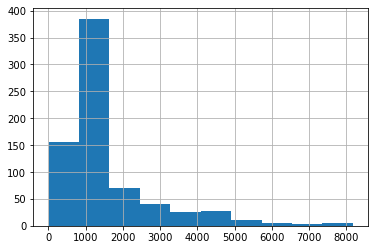

In [10]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

The newest embeddings model can handle inputs with up to 8191 input tokens so most of the rows would not need any chunking, but this may not be the case for every subpage scraped so the next code chunk will split the longer lines into smaller chunks.

In [11]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

Visualizing the updated histogram again can help to confirm if the rows were successfully split into shortened sections.

<AxesSubplot:>

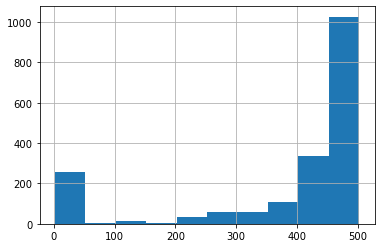

In [12]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

The content is now broken down into smaller chunks and a simple request can be sent to the OpenAI API specifying the use of the new text-embedding-ada-002 model to create the embeddings:

In [18]:
import openai

openai.api_key = os.environ["OPENAI_API_KEY"]

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,research?authors=arthur petron.,9,"[-0.004733280744403601, -0.006547232624143362,..."
1,blog dall e 2 update#OpenAI. DALL·E 2 researc...,491,"[-0.020911892876029015, -0.016629071906208992,..."
2,research?authors=amanda askell.,9,"[0.0025514927692711353, -0.015087689273059368,..."
3,research?authors=kenny hsu.,8,"[0.01220623031258583, 0.0003468284267000854, 0..."
4,careers software engineer platform reliability...,406,"[0.010812606662511826, -0.032961901277303696, ..."


### Build a Q&A System with Embeddings

Turning the embeddings into a NumPy array is the first step, which will provide more flexibility in how to use it given the many functions available that operate on NumPy arrays. It will also flatten the dimension to 1-D, which is the required format for many subsequent operations.

In [19]:
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,research?authors=arthur petron.,9,"[-0.004733280744403601, -0.006547232624143362,..."
1,blog dall e 2 update#OpenAI. DALL·E 2 researc...,491,"[-0.020911892876029015, -0.016629071906208992,..."
2,research?authors=amanda askell.,9,"[0.0025514927692711353, -0.015087689273059368,..."
3,research?authors=kenny hsu.,8,"[0.01220623031258583, 0.0003468284267000854, 0..."
4,careers software engineer platform reliability...,406,"[0.010812606662511826, -0.032961901277303696, ..."


The question needs to be converted to an embedding with a simple function, now that the data is ready. This is important because the search with embeddings compares the vector of numbers (which was the conversion of the raw text) using cosine distance. The vectors are likely related and might be the answer to the question if they are close in cosine distance. The OpenAI python package has a built in distances_from_embeddings function which is useful here.

In [21]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

The text was broken up into smaller sets of tokens, so looping through in ascending order and continuing to add the text is a critical step to ensure a full answer. The max_len can also be modified to something smaller, if more content than desired is returned.

The previous step only retrieved chunks of texts that are semantically related to the question, so they might contain the answer, but there's no guarantee of it. The chance of finding an answer can be further increased by returning the top 5 most likely results.

The answering prompt will then try to extract the relevant facts from the retrieved contexts, in order to formulate a coherent answer. If there is no relevant answer, the prompt will return “I don’t know”.

A realistic sounding answer to the question can be created with the completion endpoint using text-davinci-003.

In [23]:
def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [25]:
answer_question(df, question="What day is it?", debug=False)

"I don't know."

In [26]:
answer_question(df, question="What is the latest OPENAI model?", debug=False)

'GPT-4.'

In [27]:
answer_question(df, question="Who founded OPENAI?", debug=False)

'Greg Brockman and Ilya Sutskever founded OpenAI.'

In [28]:
answer_question(df, question="What is Jukebox?", debug=False)

'Jukebox is a neural net that generates music, including rudimentary singing, as raw audio in a variety of genres and artist styles.'

In [29]:
answer_question(df, question="What is Dall-E?", debug=False)

'DALL·E is an AI system that creates realistic images and art from a description in natural language.'

In [30]:
answer_question(df, question="Can you fine-tune ChatGPT?", debug=False)

"I don't know."

In [31]:
answer_question(df, question="What is the best way to fine-tune GPT-3?", debug=False)

'You can customize GPT-3 for your application with one command and use it immediately in our API: openai api fine_tunes.create -t.'

In [32]:
answer_question(df, question="Does OPENAI store my model outputs?", debug=False)

'No, OpenAI does not store model outputs. Data submitted by the user through the Files endpoint, for instance to fine-tune a model, is retained until the user deletes the file.'

In [33]:
answer_question(df, question="When was ChatGPT released?", debug=False)

'ChatGPT was released on November 30, 2022.'